# **Setup**

---

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%ls

Mounted at /content/gdrive
gdrive/       spark-2.4.7-bin-hadoop2.7/
sample_data/  spark-2.4.7-bin-hadoop2.7.tgz


In [ ]:
!pip install bigjson

In [ ]:
import pandas as pd
import bigjson
import json
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import explode, col, concat
from pyspark.sql.functions import when
import itertools
import numpy as np
import math
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# **View the Data**

---

### **Data Description:**
- The json objects were pretty-printed and the json objects are nested. 
- There were duplicates in the data (Same match found twice or more).
- Some champion names were not witten correctly; this caused the number of champions retrieved to be larger than what's expected.

---





In [ ]:
def vis_data (path, key):
  '''
    This is a simple function to visualize the data and understand it.
    Inputs: 
            path: path to the file with the data
            key: specific column to visualize (up to 2 nested dicts)
                  "All": if no specific column
                  "colname": specific column
                  "colname.subcol" a specific column(subcol) in the specific column (colname)
    Output:
            df: a dataframe with the desired data to visualize
  '''
  def legal(key):
    legal_keys = ['teams','participants', 'participantIdentities']
    if key not in legal_keys: 
      print("Can't be viewed as it is not a dict")
      return False
    return True 
  
  data_to_visualize = []
  with open(path, 'rb') as f:
    data = bigjson.load(f)
    for i in range(0, 5):
      #data_json = json.dumps(data[i].to_python())
      data_to_visualize.append(data[i].to_python())
    df = pd.json_normalize(data_to_visualize)
    if key != 'All':
      if "." in key:
        key1,key2 = key.split(".")
        if (legal(key1)):
          df = pd.DataFrame.from_dict(df[key1][0][0][key2])
      else:
        if (legal(key)):
          df = pd.DataFrame.from_dict(df[key][0])
    return df

In [ ]:
FILE_PATH = "gdrive/MyDrive/Big Data Projects/miniproject2/matches.json"
df_vis = vis_data(FILE_PATH,'All')
df_vis.head()

,gameId,platformId,gameCreation,gameDuration,queueId,mapId,seasonId,gameVersion,gameMode,gameType,teams,participants,participantIdentities,_id.$oid
0,1935640875,BR1,1588609318625,1656,420,11,13,10.9.318.6057,CLASSIC,MATCHED_GAME,"[{'teamId': 'Blue', 'win': 'Fail', 'firstBlood...","[{'participantId': 1, 'teamId': 'Blue', 'champ...","[{'participantId': 1, 'player': {'platformId':...",5eb3ad56b41dfd200761b66c
1,1934830844,BR1,1588533528391,1889,420,11,13,10.9.318.6057,CLASSIC,MATCHED_GAME,"[{'teamId': 'Blue', 'win': 'Fail', 'firstBlood...","[{'participantId': 1, 'teamId': 'Blue', 'champ...","[{'participantId': 1, 'player': {'platformId':...",5eb3ad56b41dfd200761b66d
2,1933813398,BR1,1588450541703,2458,420,11,13,10.9.318.6057,CLASSIC,MATCHED_GAME,"[{'teamId': 'Blue', 'win': 'Fail', 'firstBlood...","[{'participantId': 1, 'teamId': 'Blue', 'champ...","[{'participantId': 1, 'player': {'platformId':...",5eb3ad56b41dfd200761b66e
3,1932153204,BR1,1588301357666,1996,420,11,13,10.9.318.6057,CLASSIC,MATCHED_GAME,"[{'teamId': 'Blue', 'win': 'Fail', 'firstBlood...","[{'participantId': 1, 'teamId': 'Blue', 'champ...","[{'participantId': 1, 'player': {'platformId':...",5eb3ad56b41dfd200761b66f
4,1932040063,BR1,1588296188947,1703,420,11,13,10.9.318.6057,CLASSIC,MATCHED_GAME,"[{'teamId': 'Blue', 'win': 'Win', 'firstBlood'...","[{'participantId': 1, 'teamId': 'Blue', 'champ...","[{'participantId': 1, 'player': {'platformId':...",5eb3ad56b41dfd200761b670


In [ ]:
df_vis = vis_data(FILE_PATH,'participants.stats')
df_vis.head()

,participantId,win,item0,item1,item2,item3,item4,item5,item6,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,unrealKills,totalDamageDealt,magicDamageDealt,physicalDamageDealt,trueDamageDealt,largestCriticalStrike,totalDamageDealtToChampions,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageSelfMitigated,damageDealtToObjectives,damageDealtToTurrets,visionScore,timeCCingOthers,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,...,totalScoreRank,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,perk0,perk0Var1,perk0Var2,perk0Var3,perk1,perk1Var1,perk1Var2,perk1Var3,perk2,perk2Var1,perk2Var2,perk2Var3,perk3,perk3Var1,perk3Var2,perk3Var3,perk4,perk4Var1,perk4Var2,perk4Var3,perk5,perk5Var1,perk5Var2,perk5Var3,perkPrimaryStyle,perkSubStyle,statPerk0,statPerk1,statPerk2
name,1,False,Shard of True Ice,Athene's Unholy Grail,Ardent Censer,Mercury's Treads,Cloth Armor,Sapphire Crystal,Oracle Lens,2,3,6,2,1,1,413,0,0,0,0,0,41859,35811,5267,780,0,7087,5789,813,484,2946,4,4990,1555,1053,54,19,9490,2840,6376,...,0,0,0,0,0,0,0,0,0,0,0,Summon Aery,506,931,0,Manaflow Band,250,174,0,Celerity,11542,0,0,Scorch,304,0,0,Relentless Hunter,11,3,0,Eyeball Collection,16,0,0,Sorcery,Domination,Adaptive,Adaptive,Armor
from,1,False,[],"[Fiendish Codex, Chalice of Harmony]","[Forbidden Idol, Aether Wisp]","[Boots of Speed, Null-Magic Mantle]",[],[],[],2,3,6,2,1,1,413,0,0,0,0,0,41859,35811,5267,780,0,7087,5789,813,484,2946,4,4990,1555,1053,54,19,9490,2840,6376,...,0,0,0,0,0,0,0,0,0,0,0,Summon Aery,506,931,0,Manaflow Band,250,174,0,Celerity,11542,0,0,Scorch,304,0,0,Relentless Hunter,11,3,0,Eyeball Collection,16,0,0,Sorcery,Domination,Adaptive,Adaptive,Armor
into,1,False,[],[],[],[],"[Ninja Tabi, Chain Vest, Seeker's Armguard, Gl...","[Sheen, Tear of the Goddess, Catalyst of Aeons...",[],2,3,6,2,1,1,413,0,0,0,0,0,41859,35811,5267,780,0,7087,5789,813,484,2946,4,4990,1555,1053,54,19,9490,2840,6376,...,0,0,0,0,0,0,0,0,0,0,0,Summon Aery,506,931,0,Manaflow Band,250,174,0,Celerity,11542,0,0,Scorch,304,0,0,Relentless Hunter,11,3,0,Eyeball Collection,16,0,0,Sorcery,Domination,Adaptive,Adaptive,Armor
stats,1,False,"{'FlatHPPoolMod': 100, 'FlatMagicDamageMod': 45}","{'FlatSpellBlockMod': 30, 'FlatMagicDamageMod'...",{'FlatMagicDamageMod': 60},"{'FlatMovementSpeedMod': 45, 'FlatSpellBlockMo...",{'FlatArmorMod': 15},{'FlatMPPoolMod': 250},{},2,3,6,2,1,1,413,0,0,0,0,0,41859,35811,5267,780,0,7087,5789,813,484,2946,4,4990,1555,1053,54,19,9490,2840,6376,...,0,0,0,0,0,0,0,0,0,0,0,Summon Aery,506,931,0,Manaflow Band,250,174,0,Celerity,11542,0,0,Scorch,304,0,0,Relentless Hunter,11,3,0,Eyeball Collection,16,0,0,Sorcery,Domination,Adaptive,Adaptive,Armor
tags,1,False,"[GoldPer, Lane, ManaRegen, SpellDamage]","[SpellBlock, HealthRegen, SpellDamage, ManaReg...","[CooldownReduction, ManaRegen, NonbootsMovemen...","[Boots, SpellBlock, Tenacity]",[Armor],[Mana],"[Active, Trinket, Vision]",2,3,6,2,1,1,413,0,0,0,0,0,41859,35811,5267,780,0,7087,5789,813,484,2946,4,4990,1555,1053,54,19,9490,2840,6376,...,0,0,0,0,0,0,0,0,0,0,0,Summon Aery,506,931,0,Manaflow Band,250,174,0,Celerity,11542,0,0,Scorch,304,0,0,Relentless Hunter,11,3,0,Eyeball Collection,16,0,0,Sorcery,Domination,Adaptive,Adaptive,Armor


# **Challenges Faced:**
> - **First Challenge:** </br>
The first challenge was reading the data. The data file is huge and can not be read into memory for Spark to work on it. Also, the data was not in a format that Spark accepts. </br> *Solution:* </br> To solve this, the data was read using the **bigJson** library, then converted to dictionary using the **to_python()** method in the library. The dictionaries were then converted to **Json** objects and appended to a list that is passed to Spark. The bigJson library helped me to be able to read a small chunk of data at a time and process it. 
- **Second Challenge:** </br>
The second challenge was processing the data after it has been fed to Spark. The data was in the form of nested Json and the datatypes varied; to elaborate, most variables were in dict format, however, somer were found to be stored as an array which caused problems when accessing them.</br> *Solution:* </br> To solve this, the data was read using the **select** method in Spark. The desired columns were choosen using the **col()** function. If the column is nested (contains more structs or dictionaries); to access the desired sub-columns in a column, the **explode()** function was used. 
- **Third Challenge:** </br>
As I loop on the data in the form of chunks, I need to have a global entity that is updated with each chunk of data. Unfortunately, Spark does not support initializing an empty RDD or an empty dataframe (as far as I know). </br> *Solution:* </br> To solve this problem , I made the implemented functions loop first on a small chunk of the data and return a RDD that has the same desired format. I called this RDD a global RDD and updated it using the **union()** method each time the functions run on another chunk of the data.
- **Fourth Challenge:** </br> 
While doing the streaming tasks, there were two challenges, the rate limit of the API and the sparsity of data retrieved from the API. </br> *Solution:* </br> To solve the rate limit of the API, the region was changed to be **'br1'** instead of 'eun1'. The sparsity of the data was partially solved by using the statistics retrieved from other requirements such as the win rate of each champion.

**Optimizatios and Observations:** </br>
> When I tried using functions for everything, the performance of the program became much worse. After some research, I found that using functions, opening and closing a file many times is not efficient and is slow in Python. The functions are available for testing as they are more readable; however, I had to put the code in one cell and open the file once to achieve a better performance.


# **1st Requirement: Champions Win,Pick, and Ban Rates**


---



### **Win Rate Approach:**
> First, inverstigating the data to find relevant information:
- Champions names were found in the "participants" (0,1) column. Each contain five participants for each team with a total of 10 participants per match.
-  Win status can be found in the "stats" struct found in the "participants" column. The win status for each champion was then retrieved. </br> *Steps of the approach:* </br>
1.   The championId and the win status are selected from the data and the two columns are fed to Spark. 
2.   The win column is adjusted from having a bool value to having a value of 0 or 1.
3. This constructed RDD is then mapped to a tuple with a strucure of **(champion, (win, 1))**. The **1** in the win tuple is used to get the total number of games in which the champion was present while the **win** value is a 0 or 1 indicating a win or a lose.
4. The win count is then calculated by simply reducing the input tuple by key and incrementing the win, and total games values. 
5. The win rate is then the total winned games (in column win) divided by the total games played by the cahmpion multiplied by 100.
### **Pick Rate Approach:**

> Pick rate can be infered from the number of times the champion was choosen. Since we have the total number of games played by a specific champion from the previous requirement, the pick rate of a champion is simply the total number of games played by the champion divided by the total number of matches processed.

### **Ban Rate Approach:**
> First, the data was re-investigated to find the banned champions. The banned champions were found in the **"bans"** struct inside the **"teams"** column. The ban rate was simply the number of times a specific champion was found per batch.

## **Using Functions (Not Efficient)**

In [ ]:
def read_data(start,chunk,filename):
'''
This function reads the matches.json file and returns a block from it
    INPUTS:
        - start: the start index
        - chunk: the chunk size to read from the file
        - filename: the file path
    OUTPUTS:
        data_now: a list of json objects from the file
'''

  data_now = []
  with open(filename, 'rb') as f:
    data = bigjson.load(f)

    #read data
    for i in range(start, start+chunk):
      data_json = json.dumps(data[i].to_python())
      data_now.append(str(data_json))
    return data_now

def global_win(FILE_PATH, start, chunk, rdd_global, globalCount, globalBan):
'''
This function is the core function for calculating the winRate, pickRate and the banRate
      INPUTS:
          - FILE_PATH: the path to the data file
          - start: the start index to read from in the data file
          - chunk: the chunk size to be processed from the data
          - rdd_global (bool): indicates whether I want to retrieve the global RDD or do the processing.
          - globalCount: the global RDD that holds the win counts
          - globalBan: the global RDD that holds the ban counts
      OUTPUTS:
          - if rdd_global is True, it returns the winCounts and banCounts
          - if rdd_global is False, it updates the inputs(globalCount and globalBan) and returns them
'''

  data_now = read_data(start,chunk,FILE_PATH)

  #Spark read the data
  rawJson = sc.parallelize(data_now)
  rawDF = spark.read.json(rawJson)
  
  #Put champions and win value into one dataframe
  parDF = rawDF.select(explode("participants").alias("participants"))
  parWhole = parDF.select(col("participants.championId").alias("champion")
      , col("participants.stats.win").alias("win"))
      
  #replace win with 0 or 1 values
  parWhole = parWhole.withColumn("win", when(col("win")=="true", int(1)).otherwise(int(0)))
      
  #Tuple to store 3 values (champion, win, game_count)
  winCount = parWhole.rdd.map(lambda x: (x[0],(x[1],1))).reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))
  teamDF = rawDF.select(explode("teams.bans").alias("teams"))
  teamWhole = teamDF.select(explode("teams.championId").alias("BannedChampion"))
      
  #filter Nones
  teamWhole = teamWhole.filter(teamWhole.BannedChampion != 'None')
  banCount = teamWhole.rdd.map(lambda x: (x.asDict()["BannedChampion"],1)).reduceByKey(lambda x,y: x+y)
   
  if rdd_global: return winCount, banCount
  
  #update global WinCount
  globalCount = globalCount.union(winCount).reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))

  #update global ban count
  globalBan = globalBan.union(banCount).reduceByKey(lambda x,y: x+y)
  
  return globalCount,globalBan

In [ ]:
#Running the functions
FILE_PATH = "gdrive/MyDrive/Big Data Projects/miniproject2/matches.json"
total_games = 20
chunk_size = 10
num_chunks = int(total_games/chunk_size)
#Run once to intialize globals
globalCount,globalBan = global_win(FILE_PATH, 0, chunk_size, True, [],[])
#run on all the data
for i in range(1,num_chunks):
  start = chunk_size*i
  #print("Done")
  globalCount, globalBan = global_win(FILE_PATH, start, chunk_size, False, globalCount,globalBan)
  print(i)

In [ ]:
total_games = total_games + chunk_size
#################### Win Rate ###########################
winRate= globalCount.map(lambda x: (x[0], (round(((x[1][0]/x[1][1])*100),2), x[1][1]))) \
        .map(lambda x: (x[0],x[1][0],x[1][1])) \
        .toDF(['Champion','winRate %','TotalGames']).orderBy(['TotalGames','winRate %'], ascending = False)

################### Pick Rate ############################
cols = ['Champion',('pickRate % -TotalGames({})'.format(total_games))]
pickRate = globalCount.map(lambda x: (x[0],round(((x[1][1]/total_games)*100),2))) \
      .toDF(cols).orderBy(cols[1], ascending = False)

#################### Ban Rate ###########################
cols_ban = ['Champion',('BanRate % -TotalGames({})'.format(total_games))]
banRate = globalBan.map(lambda x: (x[0], round((x[1]/total_games)*100,2))) \
      .toDF(cols_ban).orderBy(cols_ban[1], ascending = False)

In [ ]:
#winRate.show()

## **Using a unified cell for the whole data:**

In [ ]:
FILE_PATH = "gdrive/MyDrive/Big Data Projects/miniproject2/matches.json"
total_games = 200
chunk_size = 10
num_chunks = int(total_games/chunk_size)
#Run once to intialize globals
globalCount,globalBan = global_win(FILE_PATH, 0, chunk_size, True, [],[]) #get globals once

In [ ]:
FILE_PATH = "gdrive/MyDrive/Big Data Projects/miniproject2/matches.json"
data_now = []
count = 1
with open(FILE_PATH, 'rb') as f:
  data = bigjson.load(f)
  while count <= num_chunks:
    start = chunk_size*count
      #read data
    for i in range(start, start+chunk_size):
      data_json = json.dumps(data[i].to_python())
      data_now.append(str(data_json))
      
    #Spark read the data
    rawJson = sc.parallelize(data_now)
    rawDF = spark.read.json(rawJson)
    #Put champions and win value into one dataframe
    parDF = rawDF.select(explode("participants").alias("participants"))
    parWhole = parDF.select(col("participants.championId").alias("champion")
          , col("participants.stats.win").alias("win"))
          
    #replace win with 0 or 1 values
    parWhole = parWhole.withColumn("win", when(col("win")=="true", int(1)).otherwise(int(0)))
          
    #Tuple to store 3 values (champion, win, game_count)
    winCount = parWhole.rdd.map(lambda x: (x[0],(x[1],1))).reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))
    teamDF = rawDF.select(explode("teams.bans").alias("teams"))
    teamWhole = teamDF.select(explode("teams.championId").alias("BannedChampion"))
          
    #filter Nones
    teamWhole = teamWhole.filter(teamWhole.BannedChampion != 'None')
    banCount = teamWhole.rdd.map(lambda x: (x.asDict()["BannedChampion"],1)).reduceByKey(lambda x,y: x+y)
          
    #update global WinCount
    globalCount = globalCount.union(winCount).reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))

    #update global ban count
    globalBan = globalBan.union(banCount).reduceByKey(lambda x,y: x+y)
    count +=1
    data_now = []

In [ ]:
total_games = total_games + chunk_size
#################### Win Rate ###########################
winRate= globalCount.map(lambda x: (x[0], (round(((x[1][0]/x[1][1])*100),2), x[1][1]))) \
        .map(lambda x: (x[0],x[1][0],x[1][1])) \
        .toDF(['Champion','winRate %','TotalGames']).orderBy(['TotalGames','winRate %'], ascending = False)

################### Pick Rate ############################
cols = ['Champion',('pickRate % -TotalGames({})'.format(total_games))]
pickRate = globalCount.map(lambda x: (x[0],round(((x[1][1]/total_games)*100),2))) \
      .toDF(cols).orderBy(cols[1], ascending = False)

#################### Ban Rate ###########################
cols_ban = ['Champion',('BanRate % -TotalGames({})'.format(total_games))]
banRate = globalBan.map(lambda x: (x[0], round((x[1]/total_games)*100,2))) \
      .toDF(cols_ban).orderBy(cols_ban[1], ascending = False)

In [ ]:
winRate.show()

+------------+---------+----------+
|    Champion|winRate %|TotalGames|
+------------+---------+----------+
|      Ezreal|    56.32|        87|
|      Thresh|    57.58|        66|
|     Lee Sin|    64.41|        59|
|      Graves|    48.15|        54|
|      Syndra|    49.02|        51|
|       Sylas|    54.17|        48|
|    Aphelios|    47.92|        48|
|      Lucian|     50.0|        42|
|        Lulu|    45.24|        42|
|       Varus|    53.85|        39|
|        Sett|    38.89|        36|
|      Kai'Sa|     50.0|        34|
|        Ekko|    44.12|        34|
|       Karma|    44.12|        34|
|       Yasuo|    33.33|        33|
|    Renekton|    59.38|        32|
|        Bard|    66.67|        30|
|       Elise|    63.33|        30|
|Miss Fortune|    62.07|        29|
|      Irelia|    44.83|        29|
+------------+---------+----------+
only showing top 20 rows



## **Visualization**

In [ ]:
#convert and save to csv file
winRate.toPandas().to_csv('gdrive/MyDrive/Big Data Projects/miniproject2/winRate.csv')
pickRate.toPandas().to_csv('gdrive/MyDrive/Big Data Projects/miniproject2/pickRate.csv')
banRate.toPandas().to_csv('gdrive/MyDrive/Big Data Projects/miniproject2/banRate.csv')

In [ ]:
#dataFile = 'gdrive/MyDrive/Big Data Projects/miniproject2/winRate_10000.csv'
#dataFile = 'gdrive/MyDrive/Big Data Projects/miniproject2/pickRate_10000.csv'
dataFile = 'gdrive/MyDrive/Big Data Projects/miniproject2/banRate_1000.csv'
#data = np.genfromtxt(dataFile, delimiter= ",", skip_header = 1, usecols = (1,2,3),
#                     converters = {1: lambda s: str(s.decode('UTF-8') or 'None')})
#data = np.genfromtxt(dataFile, delimiter= ",", skip_header = 1, usecols = (1,2),
#                     converters = {1: lambda s: str(s.decode('UTF-8') or 'None')})
data = np.genfromtxt(dataFile, delimiter= ",", skip_header = 1, usecols = (1,2),
                     converters = {1: lambda s: str(s.decode('UTF-8') or 'None')})

In [ ]:
#plot win rate with the champion
x_val = [x[0] for x in data] [0:5]
y_val = [x[1] for x in data] [0:5]
#z_val = [x[2] for x in data] [0:5]

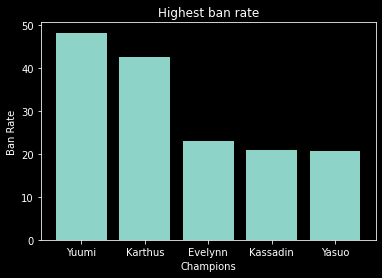

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.bar(x_val, y_val)
plt.xlabel("Champions")
plt.ylabel("Ban Rate")
plt.title("Highest ban rate")
#plt.ylabel("Win Rate")
#plt.ylabel("pick Rate")
#plt.title("Highest win rate")
#plt.title("Lowest pick rate")
plt.show()

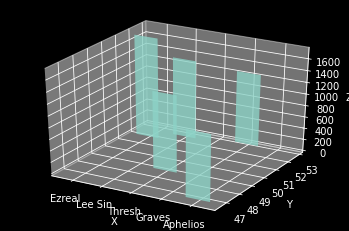

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar(x_val, z_val, y_val, zdir='y', alpha=0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# **2nd Requirement: Champion Syrengies or Duos**


---



## **Champion Synergy Approach:** 
> As before, the data is first investigated to find relevant information. The relevant information for this requirement is the columns gameId, the championId and the win status found before. </br> *Steps of the Approach:* </br>
1. After selecting the desired columns, the winRate dataframe that was found in the previous requirement is imported and put into a dictionary for local use. This is to be able to obtain a champion's win rate when needed.
2. Two RDDs are then intialized duoLose and duoWin. duoLose contains all the lost games while duoWin contains all the won games.
3. As duplicates were found in the data, duplicates are then dropped.
4. In both duoLose and duoWin a tuple is mapped having the form **(gameId, champion)**. The tuples are then reduced by key to be in the form of **(gameId, list of champions(win or lose))**.
5. Another reduce by key operation followed by a map operation are then done to transform the previous tuple into a key of the form **(champion1, champion2)** where champion1 and champion2 are in the same team (winner or loser).
6. The key (champion1, champion2) is then mapped to be **((champion1,champion2),(win, 1))** where win has a value of 0 or 1. Also, 1 is added to count the number of games the two champions had together in total.
7. The champions' duo win rate is then calculated from the previous tuple.
8. Lastly, now, we have the win rate of each champion, the total games played by each champion (from the winRate dataframe), and the duo win rate of the two champions together. The synergy factor is then calculated as follows: </br> 
> $Synergy factor = {(DuoWinRata - \sqrt{ProductOfIndividualWinr
ates})} * \frac {NumberOfDuoGames}{ProductOfNumberOfIndividualGames} $
9. The output is then saved in a dataframe and put into a csv file.

In [ ]:
#Described before
def read_data(start,chunk,filename):
  data_now = []
  with open(filename, 'rb') as f:
    data = bigjson.load(f)

    #read data
    for i in range(start, start+chunk):
      data_json = json.dumps(data[i].to_python())
      data_now.append(str(data_json))
    return data_now

def sortAlph (x):
'''
    This functions takes in a tuple and sorts its inputs alphabetically.
'''
  my_str = str(x[0])+'<t>'+str(x[1])
  words = [word for word in my_str.split('<t>')]
  words.sort()
  return (words[0], words[1])

def combinations(row):
'''
  This function takes in a list of champion names and outputs the combination of their values 
'''
  return [sortAlph(value) for value in itertools.combinations(row, 2)]

#This function calculates the synergy factor between two champions using the equation mentioned above.
def synfactor (duowin,win1,win2,duogames, game1, game2):
  return round((float(duowin)- math.sqrt(float(win1)*float(win2)))*(float(duogames)/(float(game1)*float(game2))),2)

In [ ]:
def global_syn (FILE_PATH, start, chunk, rdd_global, winRate, globalSyn):
  '''
    This function is the core function for calculating the synergy between two champions
      INPUTS:
          - FILE_PATH: the path to the data file
          - start: the start index to read from in the data file
          - chunk: the chunk size to be processed from the data
          - rdd_global (bool): indicates whether I want to retrieve the global RDD or do the processing.
          - winRate: the global RDD that holds the win counts found in the previous requiremnets
          - globalSyn: the global RDD that holds the synergy calculations across the batch
      OUTPUTS:
          - if rdd_global is True, it returns duoSyn which will be the global RDD
          - if rdd_global is False, it updates the input rdd globalSyn returns it
  '''

  data_now = read_data(start,chunk,FILE_PATH)

  #Spark read the data
  rawJson = sc.parallelize(data_now)
  rawDF = spark.read.json(rawJson)

 #Put champions and win value into one dataframe
  parDF = rawDF.select(explode("participants").alias("participants"),col('gameId').alias('gameId'))      
  parWhole = parDF.select(col('gameId').alias('gameId'), #0
                              col("participants.championId").alias("champion"), #1
                              col("participants.stats.win").alias("win")) #2
  winDict = winRate.toPandas().set_index('Champion').to_dict()

  #winners
  duoWin = parWhole.filter(parWhole.win == True)
  #losers
  duoLose = parWhole.filter(parWhole.win == False)
  #Remove duplicates from the data
  duoWin = duoWin.dropDuplicates()
  duoLose = duoLose.dropDuplicates()

  '''
      1- filter the games with the gameId and group each game's champions together
      2- get the combination of champions and get the number of win/lose games
    '''
  duoWin = duoWin.rdd.map(lambda x: (x[0],x[1])) \
      .reduceByKey(lambda x,y: x+'<t>'+y) \
      .map(lambda x: (x[0], x[1].split('<t>'))) \
      .flatMap(lambda x: combinations(x[1])) \
      .map(lambda x: (x,(1,1))).reduceByKey(lambda x,y: (x[0]+y[0] , x[1]+y[1]))
  
  duoLose = duoLose.rdd.map(lambda x: (x[0],x[1])) \
      .reduceByKey(lambda x,y: x+'<t>'+y) \
      .map(lambda x: (x[0], x[1].split('<t>'))).flatMap(lambda x: combinations(x[1])) \
      .map(lambda x: (x,(0,1))).reduceByKey(lambda x,y: (x[0]+y[0] , x[1]+y[1])) 
  
  #find the total number of games those players played together
  duoRate = duoWin.union(duoLose).reduceByKey(lambda x,y: (x[0]+y[0] , x[1]+y[1]))      
  duoRate_df = duoRate.map(lambda x: (x[0], x[1][0], x[1][1])) 
  
  duoSyn = duoRate_df.map(lambda x: ((x[0][0],x[0][1]),               #(champ1, champ2)
                                         (winDict['winRate %'][x[0][0]],    #(winRate-champ1
                                         winDict['TotalGames'][x[0][0]],  #totalGames-champ2
                                         winDict['winRate %'][x[0][1]],     #winRate-champ1
                                         winDict['TotalGames'][x[0][1]],  #totalGames-champ2
                                         x[1], x[2])))                    #duoWins #duoGamesTotal)
  if rdd_global: return duoSyn

  globalSyn = globalSyn.union(duoSyn).reduceByKey(lambda x,y: (x[0],x[1],x[2],x[3],(x[4]+y[4]),(x[5]+y[5])))

  return duoSyn

In [ ]:
FILE_PATH = "gdrive/MyDrive/Big Data Projects/miniproject2/matches.json"
total_games = 200
chunk_size = 10
num_chunks = int(total_games/chunk_size)
#Run once to intialize globals
globalSyn = global_syn (FILE_PATH, 0, chunk_size, True, winRate, [])
#run on all the data
for i in range(1,num_chunks):
  start = chunk_size*i
  globalSyn = global_syn (FILE_PATH, start, chunk_size, False, winRate, globalSyn)

In [ ]:
globalSyn= globalSyn.map(lambda x: (x[0][0],x[0][1],
                                          round((x[1][4]/x[1][5])*100,2),
                             synfactor(round((x[1][4]/x[1][5])*100), x[1][0],x[1][2],x[1][5],x[1][1],x[1][3]),
                                     x[1][5]))

In [ ]:
globalSyn = globalSyn.toDF(['champ1','champ2','duoWinRate','SynFactor','TotalGames']) \
                          .orderBy(['TotalGames', 'SynFactor','duoWinRate'], ascending = False)
#globalSyn.show()
#duoRate.collect()
#duoSyn_global.collect()

##Visualization

In [ ]:
globalSyn.toPandas().to_csv('gdrive/MyDrive/Big Data Projects/miniproject2/duoSyn.csv')

In [ ]:
converters = {1: lambda s: str(s.decode('UTF-8') or 'None'), 2: lambda s: str(s.decode('UTF-8') or 'None')}
dataFile = 'gdrive/MyDrive/Big Data Projects/miniproject2/duoSyn_1000.csv'
data = np.genfromtxt(dataFile, delimiter= ",", skip_header = 1, usecols = (1,2,3,4,5),
                     converters = converters)

In [ ]:
#plot win rate with the champion
x_val = [x[0] for x in data] [0:5]
y_val = [x[1] for x in data] [0:5]
z_val = [x[3] for x in data] [0:5]

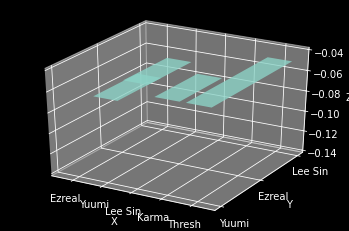

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar(x_val,y_val,z_val, alpha=0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Text(0.5, 1.0, 'Highest ban rate')

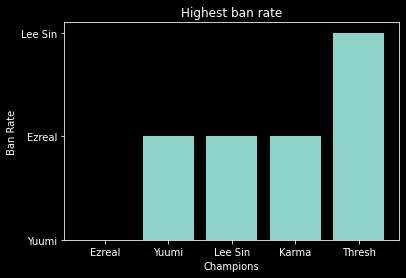

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.bar(x_val, y_val)
plt.xlabel("Champions")
plt.ylabel("Ban Rate")
plt.title("Highest ban rate")

# **3 & 4 Requirements: Streaming**


---



## **Streaming Approach:**
The data retrieved from streaming is different from the one we worked on in the previous requirements. It contains much less information about the game. However, in streaming, we can obtain access to the summoners' data which can be useful. </br>
In this part I worked on the data streamed from **'br1'** region. The variables obtained that will contribute to the prediction are: </br>
1. The champion where its win rate is used.
2. The level achieved by the summoner.
3. The total points obtained by the summoner.
4. Wthether the champion is a bot or not.
5. Whether the champion has a granted chest or not.
6. The summoner's mastery score with the champion.

> To make the prediction, the score of each summoner is calculated as follows: </br>
$Score = {level *(10*masteryScore + 5*winRate + 3*points + 5*bot + 8*chest)} $ </br>

- For threat prediction, the threat in each team is found. The threat in a team is the summoner with the highest score. </br>
- For the win prediction, I simply assumed that team whose threat has a higher score is the team that will win.


In [ ]:
%pip install riotwatcher

     |████████████████████████████████| 61kB 3.1MB/s 


In [ ]:
from riotwatcher import LolWatcher, ApiError
import time
#This function takes in a champion key and outputs the champion's name
def get_champ(champKey):
  lolWatcher = LolWatcher('XXXXXXXXXXXXXXXXXXXXXXXXXX') #please add yours
  champs = lolWatcher.data_dragon.champions('10.9.1')
  keys = list(champs['data'].keys())
  vals = []
  for key in keys:
    vals.append(champs['data'][key]['key'])
  champKeys = dict(zip(keys,vals))
  #find the key to the value
  for i in champKeys.keys():
    if champKeys[i] == champKey:
      return i

#This function finds the win rate of a specfic champion
def get_WinRate(champ_name):
  filename = 'gdrive/MyDrive/Big Data Projects/miniproject2/winRate.csv'
  df_file = pd.read_csv(filename,index_col=1)
  try:
    winRate = df_file.loc[ champ_name , 'winRate %']
  except: return 0
  return winRate
#This function gets the relevant summoner data
def get_summoner_data(x):
  lolWatcher = LolWatcher('XXXXXXXXXXXXXXXXXXX') #please add yours
  region = 'br1'
  summoner_name = x[1][0]
  champion_id = x[1][1]
  try:
    ID = lolWatcher.summoner.by_name(region,summoner_name)
    #time.sleep(1)
  except: return 'None'
  try:
    masteryScore = lolWatcher.champion_mastery.scores_by_summoner(region,ID['id'])
    #time.sleep(1)
  except: return 'None'
  try:
    masteryChampion = lolWatcher.champion_mastery.by_summoner_by_champion(region, ID['id'],champion_id)
    #time.sleep(1)
  except: return 'None'
  champion = get_champ(str(champion_id))
  winRate = get_WinRate(str(champion))
  level = masteryChampion['championLevel']
  points = masteryChampion['championPoints']
  chest = masteryChampion['chestGranted']
  return (x[0], (winRate, masteryScore, level, points,chest))

#This function calculates the score for each summoner using the information obtained.
def threat_score(x):
  winRate = x[1][0]
  masteryScore = x[1][1]
  level = x[1][2]
  points = x[1][3]
  chest = x[1][4]
  bot = x[0][3]
  keys = (x[0][0],x[0][1],x[0][2])
  score = level *(10*masteryScore + 3*points + 8*chest + 5*bot + 5*winRate)
  return (keys,round(score,2))

#This function is used to obtain the data from the server.
def get_data(APIKey, my_region):
  data_json = []
  lolWatcher = LolWatcher(APIKey)
  res = lolWatcher.spectator.featured_games(my_region)
  resData = res['gameList']
  for i in resData:
    data_json.append(json.dumps(i))
  return data_json

#This function gets the summoner that corresponds to the maximum threat
def max_team_threat(x,y):
  if x[1]>y[1]:
    maxi = x[1]
    maxi_ind = x[0]
  else:
    maxi=y[1]
    maxi_ind = y[0]
  return (maxi_ind,maxi)

In [ ]:
def threat_detection(APIKey, my_region):  
'''
  This function is the core of the threat prediction.
    INPUTS:
        - APIKey: the api key obtained from the Riot developer
        - my_region: the region one wishes to stream
    OUTPUTS:
        - threat: RDD that holds the threat summoner in each team (gameId, teamId, summoner, score)
'''

  data_json = get_data(APIKey, my_region)
  resJson = sc.parallelize(data_json)
  df = sqlContext.read.json(resJson)
  parDF = df.select(explode("participants").alias("participants"),col("gameId").alias("gameId"))
  parWhole = parDF.select(col("gameId").alias("gameId"),
                                  col("participants.teamId").alias("teamId"),
                                  col("participants.summonerName").alias("summoner"),
                                  col("participants.championId").alias("champion"),
                                  col("participants.bot").alias("bot"))
  threatPred = parWhole.rdd.map(lambda x: ((x[0], x[1], x[2], x[4]),(x[2],x[3])))\
                                .map(get_summoner_data)
  threatPredCleaned = threatPred.filter(lambda x: x != 'None')
  scores = threatPredCleaned.map(threat_score).map(lambda x: ((x[0][0],x[0][1]),(x[0][2],x[1])))
  threat = scores.reduceByKey(max_team_threat)
  return threat

In [ ]:
my_region = 'br1' #choosed this region instead of 'enu1' to overcome the rate limit issue.
APIKey = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' #please add yours
global_threat = threat_detection(APIKey, my_region)
timeout = 2   # [seconds]
timeout_start = time.time()
while time.time() < timeout_start + timeout:
  threat = threat_detection(APIKey, my_region)
  global_threat = global_threat.union(threat).reduceByKey(max_team_threat)

In [ ]:
x = global_threat.map(lambda x: (str(x[0][0]),str(x[0][1]),str(x[1][0]),str(x[1][1]))) 

In [ ]:
y= x.toDF(['GameId','Team','Summoner','SummonerScore'])
y.show()

+----------+----+----------------+-------------+
|    GameId|Team|        Summoner|SummonerScore|
+----------+----+----------------+-------------+
|2146304426| 100|Apenas SplitPush|  23693375.65|
|2146304426| 200|     MeuQ Ti ama|      2563810|
|2146343362| 100| LellisTáDeSylas|   6818270.55|
|2146343362| 200|        Tio Hero|    1003059.4|
|2146304084| 100|      Wigglytuff|    4854718.4|
|2146304084| 200|             V 4|    1372136.0|
|2146324070| 100|       SYP Empty|   4579180.55|
|2146324070| 200|volta o slide pf|   5436407.55|
|2146293856| 100|   TheSniperKing|   3087507.15|
|2146293856| 200|Shiina best girl|  75103375.55|
|2146304387| 100|          Calexe|   1294822.55|
|2146304387| 200|        Kbça1337|    6026749.4|
|2146304185| 100|           Tétsu|   13655962.6|
|2146304185| 200|   Teemo is Dead|  15701002.45|
|2146314331| 100|          Caxose|      2318645|
|2146314331| 200|iguinho el guapo|      1252686|
|2146303999| 100|  chorei no uber|  17377820.25|
|2146303999| 200|   

In [ ]:
#Test another method to get more information
API = 'RXXXXXXXXXXXXXXXXXxx' #please add yours
my_region = 'br1'
lolWatcher = LolWatcher(API)
res = lolWatcher.spectator.featured_games(my_region)
resData = res['gameList']
ID = lolWatcher.summoner.by_name(my_region,'Darknesmad')
lis = lolWatcher.match.matchlist_by_account(my_region,'nUbzhoTciLXLb8LOGX8zY0iJR6KkMVQuPl_K82KYsgaZoBs')
#lis
game = lolWatcher.match.by_id(my_region,2027757865)
game

{'gameCreation': 1597032691999,
 'gameDuration': 1132,
 'gameId': 2027757865,
 'gameMode': 'ARAM',
 'gameType': 'MATCHED_GAME',
 'gameVersion': '10.16.330.9186',
 'mapId': 12,
 'participantIdentities': [{'participantId': 1,
   'player': {'accountId': '7v_dX5-qYsrsZj8X4wQ6F_2CxnF-E0oMBSoZKi6zatFyYmg',
    'currentAccountId': '7v_dX5-qYsrsZj8X4wQ6F_2CxnF-E0oMBSoZKi6zatFyYmg',
    'currentPlatformId': 'BR1',
    'matchHistoryUri': '/v1/stats/player_history/BR1/215025335',
    'platformId': 'BR1',
    'profileIcon': 666,
    'summonerId': '0Usu25NX4q1G1xXRSs9S5XNYd_n5Vqjl7rEvwNHK8IMBNuM',
    'summonerName': 'T1RAN0'}},
  {'participantId': 2,
   'player': {'accountId': 'nUbzhoTciLXLb8LOGX8zY0iJR6KkMVQuPl_K82KYsgaZoBs',
    'currentAccountId': 'nUbzhoTciLXLb8LOGX8zY0iJR6KkMVQuPl_K82KYsgaZoBs',
    'currentPlatformId': 'BR1',
    'matchHistoryUri': '/v1/stats/player_history/BR1/207413357',
    'platformId': 'BR1',
    'profileIcon': 3791,
    'summonerId': 'dpaHVXYVKYzZwH8LSG5fAr3A0d1BaGli8r

## **Win Prediction**

> In this part, the winner is found based on the threat found above. If a team's threat has a higher score than the other team's threat, this team is the winner.

In [ ]:
def win_team(x,y):
'''
  This function finds the winner team by finding the 
'''
  if y[1] > x[1]:
    maxi = y[1]
    maxi_ind = y[0]
  else:
    maxi = x[1]
    maxi_ind = x[0]
  return (maxi_ind, maxi)

def win_prediction(global_threat):
'''
  This function finds the winner team
'''
  winPredict = global_threat.map(lambda x: (x[0][0],(x[0][1],x[1][1]))).reduceByKey(win_team) \
                            .map(lambda x: (str(x[0]),str(x[1][0]),str(x[1][1])))
  return winPredict

In [ ]:
winners = win_prediction(global_threat)
winDF = winners.toDF(['GameID','WinnerTeam','MaxTeamScore'])
winDF.show()

+----------+----------+------------+
|    GameID|WinnerTeam|MaxTeamScore|
+----------+----------+------------+
|2146304426|       100| 23693375.65|
|2146343362|       100|  6818270.55|
|2146304084|       100|   4854718.4|
|2146324070|       200|  5436407.55|
|2146293856|       200| 75103375.55|
|2146304387|       200|   6026749.4|
|2146304185|       200| 15701002.45|
|2146314331|       100|     2318645|
|2146303999|       200|  37334383.1|
+----------+----------+------------+



# **5th Requirement: Items Win and Pick Rates**

---

## **Items Win and Pick Rates Approach:**
The fist step, as always, is investigating the data searching for relevant information. To find the win and pick rates, we should get the 7 items names, the win status and gameId from the data. The names of the items are found in the **"participants.item(0-6).name"** while the rest are retrieved as before. </br> 
*Steps of the approach:*
1. The 7 items along with their win status and the gameId are retrieved from the data. 
2. The win status column values are changed to be 0 or 1 instead of true and false.
3. The inputs are then mapped to be in the form of **(items_list, win_status)**. This tuple is then sent to a **diverge()** function which outputs a list of tuples in the form of **(item, (win_status, 1))**. 
4. The pick count and the win count are then infered from the tuple and returned.
5. The win rate will be the the number of wins divided by the total games the item was found in.
6. The pick rate is more tricky as one item can be picked more than once in one game. So, in order to calculate the pick rate, the data is put in the form of the tuple, **(gameId, item, number_of_picks per game, number_of_picks per batch)**. At the end, the average picks per game along with the pick rate accross the batch are calculated.

In [ ]:
#As before, this reads the data from the file
def read_data(start,chunk,filename):
  data_now = []
  with open(filename, 'rb') as f:
    data = bigjson.load(f)
    #read data
    for i in range(start, start+chunk):
      data_json = json.dumps(data[i].to_python())
      data_now.append(str(data_json))
    return data_now

def diverge(x):
'''
    This function diverges the list of elements such that its output is (item, win_status, total_num_of_games)
'''
  items = []
  for i in x[0]:
    if (i):
      items.append((i, (x[1], 1))) #(item, win[0 or 1] , num_of_games iterator)
  return items

def diverge_pick(x):
'''
    same as before, but for the pickRate requirement. 
    The output is then (gameId, item, number_of_picks per game, number_of_picks per batch)
'''
  items = []
  for i in x[1]:
    if (i):
      items.append(((x[0],i),(1,1))) #(gameId, item, number_of_picks per game, number_of_picks per batch)
  return items


In [ ]:
def item_win_pick (FILE_PATH, start, chunk, rdd_global, itemCount_global, pickCount_global):
'''
This function is the core of calculating the pick and win rates of items.
      INPUTS:
          - FILE_PATH: the path to the data file.
          - start: ths start index in the file.
          - chunk: the size of chunk to be read from the file.
          - rdd_global: (bool) to indicate if this is a run through the whole file or a run to get the global RDD.
          - itemCount_global: RDD that contains the item counts.
          - pickCount_global: RDD that contains the item picks.

      OUTPUTS:
          - if rdd_global = True: itemCount, pickCount
                  returns an rdd to save all the values in. 

          - if rdd_global = False: itemCount_global, pickCount_global
                  updates the global inputs and outputs the updated version.
'''

  data_now = read_data(start,chunk,FILE_PATH)
  #Spark read the data
  rawJson = sc.parallelize(data_now)
  rawDF = spark.read.json(rawJson)
  #Put champions and win value into one dataframe
  parDF = rawDF.select(explode("participants.stats").alias("participants"),col("gameId").alias('gameId'))
  parWhole = parDF.select(col("gameId").alias('gameId'),
                          col("participants.item0.name").alias("item0"),
                          col("participants.item1.name").alias("item1"),
                          col("participants.item2.name").alias("item2"),
                          col("participants.item3.name").alias("item3"),
                          col("participants.item4.name").alias("item4"),
                          col("participants.item5.name").alias("item5"),
                          col("participants.item6.name").alias("item6"),
                          col("participants.win").alias("win"))
  
  parWhole = parWhole.withColumn("win", when(col("win")=="true", int(1)).otherwise(int(0)))
  itemCount =  parWhole.rdd.map(lambda x: ([x[1],x[2],x[3],x[4],x[5],x[6],x[7]],x[8])).map(diverge).flatMap(lambda x: x) \
                            .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))
  
  pickCount = parWhole.rdd.map(lambda x: (x[0],[x[1],x[2],x[3],x[4],x[5],x[6],x[7]])).map(diverge_pick).flatMap(lambda x:x) \
                      .reduceByKey(lambda x,y:(x[0]+y[0], x[1])) \
                      .map(lambda x: (x[0][1],(x[1][0],x[1][1]))) \
                      .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])) #item, sum pick per game, total number games
  
  if rdd_global: return itemCount, pickCount
  
  itemCount_global = itemCount_global.union(itemCount).reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))
  pickCount_global = pickCount_global.union(pickCount).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
  
  return itemCount_global,pickCount_global

In [ ]:
FILE_PATH = "gdrive/MyDrive/Big Data Projects/miniproject2/matches.json"
total_games = 200
chunk_size = 10
num_chunks = int(total_games/chunk_size)
#Run once to intialize globals
itemCount_global, pickCount_global = item_win_pick(FILE_PATH, 0, chunk_size, True, [],[])
#run on all the data
for i in range(1,num_chunks):
  start = chunk_size*i
  itemCount_global, pickCount_global = item_win_pick(FILE_PATH, start, chunk_size, False, itemCount_global, pickCount_global)

In [ ]:
pickCal = pickCount_global.map(lambda x: (x[0],round((x[1][0]/x[1][1]),2) ,round((x[1][1]/total_games)*100,2))) \
                                    .toDF(['item','pickRate_per_game', 'pickRate_per_batch']) \
                                  .orderBy(['pickRate_per_batch','pickRate_per_game'], ascending = False)
pickCal.toPandas().to_csv('gdrive/MyDrive/Big Data Projects/miniproject2/ItempickRate.csv')
pickCal.show()

+--------------------+-----------------+------------------+
|                item|pickRate_per_game|pickRate_per_batch|
+--------------------+-----------------+------------------+
|         Oracle Lens|             3.99|              99.5|
|Warding Totem (Tr...|             3.35|              98.0|
| Farsight Alteration|             2.76|              96.0|
|        Control Ward|             2.27|              92.0|
|    Sorcerer's Shoes|             1.96|              91.5|
|          Ninja Tabi|             2.32|              83.0|
| Berserker's Greaves|             1.69|              83.0|
|    Mercury's Treads|             2.15|              75.5|
|       Doran's Blade|              2.1|              73.5|
|       Black Cleaver|             1.55|              73.5|
|Blade of the Ruin...|             1.59|              71.5|
|Enchantment: Warrior|             1.23|              65.0|
|       Infinity Edge|             1.38|              61.5|
|   Corrupting Potion|             1.52|

In [ ]:
itemCount_global = itemCount_global.map(lambda x: (x[0], round((x[1][0]/x[1][1])*100,2))).toDF(['item','winRate']) \
                                    .orderBy(['winRate'], ascending = False)
itemCount_global.show()
itemCount_global.toPandas().to_csv('gdrive/MyDrive/Big Data Projects/miniproject2/ItemwinRate.csv')


+--------------------+-------+
|                item|winRate|
+--------------------+-------+
|Rabadon's Deathcrown|  100.0|
|    Zhonya's Paradox|  100.0|
|           Salvation|  100.0|
|Might of the Ruin...|  100.0|
|     Spectral Sickle|  100.0|
| Mejai's Soulstealer|  80.49|
|      Randuin's Omen|  77.78|
|      Warmog's Armor|  77.78|
|        Abyssal Mask|   75.0|
|         Spellbinder|   75.0|
|      Guardian Angel|  73.08|
| Aegis of the Legion|  71.11|
|      Ravenous Hydra|  70.83|
|        Knight's Vow|  68.97|
|       Titanic Hydra|  68.75|
|      Spectre's Cowl|   68.0|
|    Hextech Gunblade|   68.0|
|      Trinity Fusion|  66.67|
|       Frozen Mallet|  66.67|
|        Relic Shield|  66.67|
+--------------------+-------+
only showing top 20 rows



# Visualization:

In [ ]:
converters = {1: lambda s: str(s.decode('UTF-8') or 'None')}
dataFile = 'gdrive/MyDrive/Big Data Projects/miniproject2/ItemwinRate.csv'
data = np.genfromtxt(dataFile, delimiter= ",", skip_header = 1, usecols = (1,2,3),
                     converters = converters)

In [ ]:
#plot win rate with the champion
x_val = [x[0] for x in data] [-3:]
y_val = [x[1] for x in data] [-3:]
z_val = [x[2] for x in data] [-3:]

Text(0.5, 1.0, 'Lowest picked items per sample data')

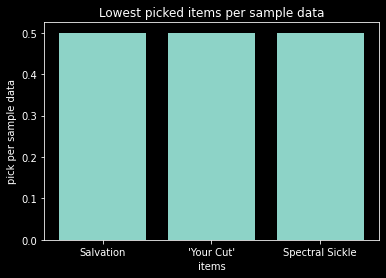

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.bar(x_val, z_val)
plt.xlabel("items")
plt.ylabel("pick per sample data")
plt.title("Lowest picked items per sample data")

# **Creative Requirements**


---



**Thoughts:**
- Which role/lane fits a certain champion? (high win rate?)
- Worst threats for each champion? (When that champion is present in the opposite team the champion has a high lose rate)
- Runes for each champion?

## **Counters for each champion**

### **Counters for each champion Approach:**
As always, the data was investigated to extract the relevant informations. The columns needed for this task are the gameId, the championId, and the win status. </br>
*Steps of the Approach:* </br>
1. The data is first mapped to be **(gameId, (championId, win_status))**. 
2. The previous tuple is then reduced by key using the **findCounters()** function to output a tuple that has the form of (champion1, champion2) where champion1 is always the loser and champion2 is always the winner. This tuple is then mapped to be **((champion1,champion2),1)** where the addition of 1 will indicate the number of games in which champion1 lost and champion2 won.
3. The previous tuple is again reduced by key to get the counts of that combination. 
4. The tuple is then mapped to be **(loser, (winner, count))**. Again the tuple is reduced by key; the tuple in which the count has the maximum value, its winner champion will be the worst counter for the first champion.
5. Lastly, the output is a champion (loser), its worst counter, and the number of games in which the first champion lost.

In [ ]:
#a function to read the data from the file.
def read_data(start,chunk,filename):
  data_now = []
  with open(filename, 'rb') as f:
    data = bigjson.load(f)

    #read data
    for i in range(start, start+chunk):
      data_json = json.dumps(data[i].to_python())
      data_now.append(str(data_json))
    return data_now

#this function gets the
def max_counter(x,y):
  if x[1]>y[1]:
    maxi = x[1]
    maxi_ind = x[0]
  else:
    maxi=y[1]
    maxi_ind = y[0]
  return (maxi_ind,maxi)

def findCounters(x,y):
'''
    This function checks if two champions are in the same team (by checking if both win or not); 
    then outputs a tuple of the counter champions.

'''
  if x[1] == True: 
    return (y[0],x[0])
  else:
    return (x[0],y[0]) 

In [ ]:
def counter_wins (FILE_PATH, start, chunk, rdd_global, globalCounter):
'''
This function is the core of finding the worst counters for each champion.
      INPUTS:
          - FILE_PATH: the path to the data file.
          - start: ths start index in the file.
          - chunk: the size of chunk to be read from the file.
          - rdd_global: (bool) to indicate if this is a run through the whole file or a run to get the global RDD.
          - globalCounter: RDD that contains the counter champion counts.
      OUTPUTS:
          - if rdd_global = True: Championcounters
                  returns an rdd to save all the values in. 

          - if rdd_global = False: globalCounter
                  updates the global inputs and outputs the updated version.
'''

  data_now = read_data(start,chunk,FILE_PATH)

  #Spark read the data
  rawJson = sc.parallelize(data_now)
  rawDF = spark.read.json(rawJson)
    
  #Put champions and win value into one dataframe
  parDF = rawDF.select(explode("participants").alias("participants"),col('gameId').alias('gameId'))
  parWhole = parDF.select(col('gameId').alias('gameId'),
                            col("participants.championId").alias("champion"),
                            col("participants.stats.win").alias("win"))
  parWhole = parWhole.withColumn("win", when(col("win")=="true", int(1)).otherwise(int(0)))
  counte = parWhole.rdd.map(lambda x: (x[0],(x[1],x[2]))).reduceByKey(findCounters).map(lambda x: (x[1],1))\
                          .reduceByKey(lambda x,y: x+y)
  Championcounters = counte.map(lambda x: (x[0][0], (x[0][1], x[1]))).reduceByKey(max_counter)

  if rdd_global: return Championcounters
  
  #update global CounterChamps
  globalCounter = globalCounter.union(Championcounters).reduceByKey(max_counter)
  
  return globalCounter

In [ ]:
FILE_PATH = "gdrive/MyDrive/Big Data Projects/miniproject2/matches.json"
total_games = 200
chunk_size = 10
num_chunks = int(total_games/chunk_size)
#Run once to intialize globals
globalCounters = counter_wins (FILE_PATH, 0, chunk_size, True, [])
#run on all the data
start = chunk_size
for i in range(1,num_chunks):
  start = chunk_size*i
  globalCounters = counter_wins (FILE_PATH, start, chunk_size, False, globalCounters)

In [ ]:
globalCounters = globalCounters.map(lambda x: (x[0], x[1][0], x[1][1])).toDF(['champion', 'worstCounter', 'count']) \
                                .orderBy(['count'], ascending = False)

In [ ]:
#globalCo100unters.show()
globalCounters.toPandas().to_csv('gdrive/MyDrive/Big Data Projects/miniproject2/counterChamps.csv')

In [ ]:
globalCounters.show()
#Not representative at allllllll

+--------------+------------+-----+
|      champion|worstCounter|count|
+--------------+------------+-----+
|Nunu & Willump|    Renekton|    1|
|           Zoe|        Sett|    1|
|      Aphelios|       Akali|    1|
|       Kindred|        Pyke|    1|
|  Miss Fortune|         Zoe|    1|
|         Karma|        Bard|    1|
|         Akali|        Jhin|    1|
|         Senna|      Lucian|    1|
|       LeBlanc|Twisted Fate|    1|
|         Yasuo|       Quinn|    1|
|       Evelynn|    Nautilus|    1|
|  Aurelion Sol|      Graves|    1|
|        Thresh|         Jax|    1|
|        Ezreal|       Shaco|    1|
|          Bard|        Jhin|    1|
|        Darius|     Taliyah|    1|
|        Kai'Sa|       Amumu|    1|
|         Shaco|       Janna|    1|
|         Corki|     Morgana|    1|
|        Wukong|       Corki|    1|
+--------------+------------+-----+
only showing top 20 rows

